<a href="https://colab.research.google.com/github/COTILab/MCX24Workshop/blob/master/Training/MCX2024_1D_mcxlab_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Workshop Logo](https://mcx.space/wiki/upload/mcx24_logo.png)
# MCX Training Workshop 2024 - Day 1, Session 1D

## Session 1D: MCXLAB Training


# <font color='orange'>Step 0: Setting up MCX and Octave environments within Google Colab</font>

> **You must rerun all cells in Step 0 in appearance order when you start a new session, or after reconnect to a runtime**

To run interactive Octave sessions inside a Google Colab Jupyter Notebook environment, we need to install the following dependencies
- GNU Octave via `sudo apt-get install octave`
- Oct2py Python module via `pip install oct2py`, and
- enable Oct2py in Jupyter Notebook via "magic command" `%load_ext oct2py.ipython`

<font color='green'>If you run this on Google Colab, please go to menu **Edit\Notebook Settings\Hardware accelerator**, and verify if it has already selected "GPU"; if not, please select the T4 GPU.</font>

**Please note**: MCX/MCXLAB is GPU-accelerated. This notebook by default requests an NVIDIA GPU. Howevever, when you click on the run-button for the below section, your browser may fail to allocate a GPU runtime and ask you if you want to continue with a non-GPU runtime. If you choose to proceed without GPU support, you will have to run the [section immediately following the next section](#mcx_setup_opencl) to install OpenCL-based MCXLAB (called mcxlabcl) and utilize the CPU to run the rest of the tutorials. The OpenCL version of MCXLAB will work for all examples, but will be substentially slower to run (this tutorial also reduces the photon numbers accordingly to lower the runtime).

In [ ]:
#@title <font color='orange'>Init 1: Initial setup of environment for running MCXLAB (run the below section once)</font>

# install octave and oct2py
! apt-get update && apt-get install octave jq libpocl2 pocl-opencl-icd libnvidia-compute-535   # install octave (a free matlab clone), jq and OpenCL runtimes
! python3 -m pip install oct2py jdata bjdata matplotlib   # install oct2py, jdata, bjdata and matplotlib Python modules

# add octave support to colab notebook
%load_ext oct2py.ipython

# download and unzip MCXStudio
! rm -rf MCXStudio*
! curl https://mcx.space/nightly/release/MCX24/MCXStudio-linux-x86_64-nightlybuild.zip -O MCXStudio-linux-x86_64-nightlybuild.zip # download MCX suite
! unzip -o MCXStudio-linux-x86_64-nightlybuild.zip && rm -rf MCXStudio-linux-x86_64-nightlybuild.zip # unzip MCX suite

# add executable to the shell's paths
! cp -a "$PWD/MCXStudio/MCXSuite/mcx/bin/mcx*" "$PWD"
! cp -a "$PWD/MCXStudio/MCXSuite/mcxcl/bin/mcxcl*" "$PWD"
! cp -a "$PWD/MCXStudio/MCXSuite/mmc/bin/mmc*" "$PWD"
! cp -a "$PWD/MCXStudio/MATLAB/zmat/octave/gnu-linux-x86_64/zipmat.mex" "$PWD/MCXStudio/MATLAB/zmat/"

# if a GPU runtime can not be allocated, run this section to setup OpenCL and MCXLAB-CL
! [[ ! -f `which nvidia-smi` ]] && mv "$PWD/mcxcl" "$PWD/mcx"
! mcx -L

### <font color='orange'>Init 2: Only need to run this once at the beginning</font>

In [18]:
%%octave
addpath([pwd filesep 'MCXStudio/MATLAB/mcxlab']);                 % add path to mcxlab
addpath([pwd filesep 'MCXStudio/MCXSuite/mcx' filesep 'utils']);  % add path to mcx helper functions
addpath([pwd filesep 'MCXStudio/MATLAB/mmclab']);                 % add path to mmclab
addpath([pwd filesep 'MCXStudio/MCXSuite/mmc' filesep 'matlab']); % add path to mmc helper functions
addpath([pwd filesep 'MCXStudio/MATLAB/iso2mesh']);               % add path to iso2mesh/jsonlab
addpath([pwd filesep 'MCXStudio/MATLAB/brain2mesh']);             % add path to brain2mesh
addpath([pwd filesep 'MCXStudio/MATLAB/zmat']);                   % add path to zmat for data compression
addpath([pwd filesep 'MCXStudio/MATLAB/redbird-m/matlab']);              % add path to brain2mesh
addpath([pwd filesep 'MCXStudio/MATLAB/hyperspectral_demo']);     % add path to hyperspectral_demo for exec 4

struct_levels_to_print(0);
print_struct_array_contents(0);

if(system('which nvidia-smi'))                   % if this runtime does not have NVIDIA GPU support
    addpath([pwd filesep 'MCXStudio/MATLAB/mcxlabcl']);    % add path to mcxlabcl
    USE_MCXCL=1;                                 % set USE_MCXCL flag in the base workspace
end

/opt/bin/nvidia-smi

### <font color='orange'>Init 3: Verify your environments</font>

---

In [3]:
%%octave

which mcx
which s2m
which zipmat

mcxlab('gpuinfo')     % use this command to list supported CPU or GPU in octave
unix('./mcx -L')        % use -L flag to list GPU in the command line

'mcx' is a function from the file /content/MCXStudio/MATLAB/mcxlab/mcx.mex

's2m' is a function from the file /content/MCXStudio/MATLAB/iso2mesh/s2m.m

'zipmat' is a function from the file /content/MCXStudio/MATLAB/zmat/zipmat.mex

=============================   GPU Information  ================================

Device 1 of 1:		Tesla T4

Compute Capability:	7.5

Global Memory:		15835660288 B

Constant Memory:	65536 B

Shared Memory:		49152 B

Registers:		65536

Clock Speed:		1.59 GHz

Number of SMs:		40

Number of Cores:	2560

Auto-thread:		81920

Auto-block:		64

ans =

  scalar structure containing the fields:

    name: 1x8 sq_string

    id: 1x1 scalar

    devcount: 1x1 scalar

    major: 1x1 scalar

    minor: 1x1 scalar

    globalmem: 1x1 scalar

    constmem: 1x1 scalar

    sharedmem: 1x1 scalar

    regcount: 1x1 scalar

    clock: 1x1 scalar

    sm: 1x1 scalar

    core: 1x1 scalar

    autoblock: 1x1 scalar

    autothread: 1x1 scalar

    maxgate: 1x1 scalar

sh: 1: ./mcx: not found

ans = 127

# MCXLAB Primer

MCXLAB is the **MATLAB/Octave wrapper/bindings** to the MCX GPU-based photon simulation codes.

The mex file, `mcx.mex` (or `mcx.mexa64` etc) is basically a dynamic library similar to a .DLL file on Windows (or .so in Linux, or .dylib in MacOS), and is compiled using the identical CUDA/C-code as used to build the command line based MCX. As a result, the simulation is performed nearly identically. Aside from the MATLAB/Octave binding, we also provide the Python binding in the form of a binary Python module called `pmcx`. The idea is the same as MCXLAB, but an dynamic library interface that can be called in Python.

The major difference between mcx executable, MCXLAB, and pmcx is the user input/output handling.

- User inputs:
  - MCX JSON input file -> MATLAB `cfg` struct
  - input volume file -> `cfg.vol`
  - command line options -> `cfg.issavedet`, `cfg.isreflect`, `cfg.isnormalized` ...
- Data outputs: `[flux, detp, vol, seeds, traj]=mcxlab(cfg)`
  - volumetric output (`session.jnii`) -> `flux.data`: first output of mcxlab
  - detected photon output (`session_detp.jdat`) -> `detp.{detid, ppath, ...}`: second output of mcxlab
  - trajectory output (`session_traj.jdat`) -> `traj.{id,p,w0}`: 5h output of mcxlab

Below is a diagram showing the file-based input/output of MCX in the binary mode

![MCX command line IO](https://mcx.space/wiki/upload/mcxlab-mcx_io.svg)


In comparison, here is the diagram showing the input/output of MCXLAB (both input and outputs are in-memory variables)

![MCXLAB IO](https://mcx.space/wiki/upload/mcxlab-io.svg)

The below diagram showing more details of the input/output data fields of the `mcxlab` wrapper function

![MCXLAB input/output](https://mcx.space/wiki/upload/mcxlab-cfg.svg)

A mapping table between JSON-input-file fields, command line flags, and cfg data fields for MCX/MCXCL and MMC can be found below (click on the image to see enlarged image)

<a href="http://mcx.space/wiki/upload/mcx_flags_list.png"><img src="http://mcx.space/wiki/upload/mcx_flags_list.png" width="1600"></a>


## A starter example

---



The first thing to do is to list the usable GPU on your system. You should use `mcxlab('gpuinfo')`. If there is one or more GPU, you should see GPU information printed in the below cell.

`mcxlab('gpuinfo')` returns all available GPU's detailed information as a struct array, shown as variable `gpus` below.

In [ ]:
%%octave

gpus = mcxlab('gpuinfo')
gpus.core

Now you can run a simple simulation below

In [7]:
%%octave
clear cfg

% make sure you terminate each statement by ';' so no excessive printing that could overwhelm the runtime

%% the below fields are minimumally required to define an MCX simulation
cfg.nphoton=1e6;                   % define how many photon packets to simulate

%% define domain in the form of a labeled volume - each voxel is an integer denoting tissue type ID
cfg.vol=uint8(ones(60,60,60));     % define a label-based volume - each voxel has a integer defining the medium type
cfg.vol(20:40, 30:40, 20:30)=2;    % adding an inclusion by setting to a different label

%% the optical properties of the i-th tissue type must be defined in the (i+1)-th row of cfg.prop
cfg.prop=[0 0 1 1;                 % cfg.prop defines the optical properties, one medium per row; first row is for medium label 0 (background)
          0.005 0.2 0 1.37;        % cfg.prop has 4 columns, in the order [mua(1/mm), mus(1/mm), g(anisotropy), n(ref index)]; 2nd row for medium type 1
          0.1, 2, 0.9, 1];         % third row is for medium type 2, and so on

%% a simulation must have source defined, default type is a pencil beam (cfg.srctype='pencil')
cfg.issrcfrom0=1;                  % if this is not defined, cfg.srcpos and cfg.detpos will subtract 1 in x/y/z
cfg.srcpos=[30 30 1];              % source position in voxel-units
cfg.srcdir=[0 0 1];                % source direction (a unitary vector)
cfg.detpos=[30,27,1,1];            % a detector that is 3 mm away from source with a radius 1 mm

%% other key parameters
cfg.tstart=0;                      % define the start time of the simulation (in s)
cfg.tend=5e-9;                     % define the maximum duration of the photon packet (in s)
cfg.tstep=1e-10;                   % this defines 50 time gates, (tend-tstart)/tstep; when tstep=tend, it defines a single time window, producing a CW solution

%% cfg.gpuid specifies which GPU to use, default is the first GPU
cfg.gpuid=1;                       % use the first GPU (default), can use strings of '01' masks to use multiple GPU, such as '0110'

% reduce photon number on runtimes without a GPU (i.e. CPU only)
if(exist('USE_MCXCL', 'var') && USE_MCXCL==1)  % if no GPU is found, run less photon on the CPU
    cfg.nphoton=1e5;               % define how many photon packets to simulate
end

Run the above simulation by calling `mcxlab()`

Running this section for the first time can be slightly slow as CUDA needs to initialize the GPU device. Running again should take less than a second.

In [ ]:
%%octave

fluencerate=mcxlab(cfg);
fieldnames(fluencerate)

size(fluencerate.data)

cwfluence=sum(fluencerate.data,4);

imagesc(log10(squeeze(cwfluence(:,30,:))))
colorbar
axis equal

## A starter+ example

Let's go over the below updated cfg struct. A few additions were made compared to the earlier example

- we enable the saving of diffuse reflectance (`cfg.issaveref=1`) along all 6 bounding box faces - to do this, we must pad a layer of zero-voxels around the volume
- we disabled normalization in order to inspect energy conservation
- we output raw energy deposition instead of fluence-rate

In [ ]:
%%octave
clear cfg

% make sure you terminate each statement by ';' so no excessive printing that could overwhelm the runtime

%% the below fields are minimumally required to define an MCX simulation
cfg.nphoton=1e7;                   % define how many photon packets to simulate

%% define domain in the form of a labeled volume - each voxel is an integer denoting tissue type ID
cfg.vol=uint8(zeros(60,60,60));     % define a label-based volume - each voxel has a integer defining the medium type
cfg.vol(2:end-1,2:end-1,2:end-1)=1; % define a label-based volume - each voxel has a integer defining the medium type
cfg.vol(20:40, 30:40, 20:30)=2;    % adding an inclusion by setting to a different label

%% save diffuse reflectanct at z=0 plane - total light escaped from the bottom plane
cfg.issaveref=1;                   % save diffuse reflectance - can only save to the 0-valued voxel next to a boundary

%% the below two settings allow us to verify energy-conservation in MCX
cfg.isnormalized=0;                % disable normalization
cfg.outputtype='energy';           % save energy deposition
cfg.isspecular=0;                  % save energy deposition

%% the optical properties of the i-th tissue type must be defined in the (i+1)-th row of cfg.prop
cfg.prop=[0 0 1 1;                 % cfg.prop defines the optical properties, one medium per row; first row is for medium label 0 (background)
          0.005 0.2 0 1.37;          % cfg.prop has 4 columns, in the order [mua(1/mm), mus(1/mm), g(anisotropy), n(ref index)]; 2nd row for medium type 1
          0.1, 2, 0.9, 1];        % third row is for medium type 2, and so on

%% a simulation must have source defined, default type is a pencil beam (cfg.srctype='pencil')
cfg.issrcfrom0=1;                  % if this is not defined, cfg.srcpos and cfg.detpos will subtract 1 in x/y/z
cfg.srcpos=[30 30 1];              % source position in voxel-units
cfg.srcdir=[0 0 1];                % source direction (a unitary vector)
cfg.detpos=[30,27,1,1];            % a detector that is 3 mm away from source with a radius 1 mm

%% other key parameters
cfg.tstart=0;                      % define the start time of the simulation (in s)
cfg.tend=5e-9;                     % define the maximum duration of the photon packet (in s)
cfg.tstep=1e-10;                   % this defines 50 time gates, (tend-tstart)/tstep; when tstep=tend, it defines a single time window, producing a CW solution

%% cfg.gpuid specifies which GPU to use, default is the first GPU
cfg.gpuid=1;                       % use the first GPU (default), can use strings of '01' masks to use multiple GPU, such as '0110'

% reduce photon number on runtimes without a GPU (i.e. CPU only)
if(exist('USE_MCXCL', 'var') && USE_MCXCL==1)  % if no GPU is found, run less photon on the CPU
    cfg.nphoton=1e5;               % define how many photon packets to simulate
end

Run below cell

In [ ]:
%%octave
% calculate the fluence-rate distribution with the given config
fluencerate=mcxlab(cfg);

fieldnames(fluencerate)

% fluencerate.stat records some basic simulation
fluencerate.stat
size(fluencerate.data)

cwfluence=sum(fluencerate.data, 4);
contourf(log10(squeeze(cwfluence(30,:,:))), 30);
axis equal
colorbar
colormap('jet')

%% show (unnormalized) diffuse reflectance at z=0 plane
size(fluencerate.dref)
dref=sum(fluencerate.dref, 4); % sum the 4th dimension, whcih is time-gates, providing the CW solution
figure;
contourf(log10(dref(:,:,1)),20)

%% verify energy deposition
total_absorbed=sum(fluencerate.data(:))
total_escaped=sum(fluencerate.dref(:))
total_launched=total_absorbed + total_escaped

## Exec 1 - Using complex sources and source control

In the below exercise, we show you various control flags related to light source, launch angle, and focal length control etc.

- Specifically, the 4th element of `cfg.srcdir` controls the focal length for any "focusable" source - including area and line sources ("gaussian", "planar","fourier", "arcsine", "disk", "fourierx", "fourierx2d", "zgaussian", "line", "slit", "pencilarray", "hyperboloid", "ring", "pattern", "pattern3d"), where
   - if `focallength=cfg.srcdir(4)` is unset or set to 0, all photons are launched collimated along the direction defined by `cfg.srcdir(1:3)`
   - when `focallength=cfg.srcdir(4)` > 0, it simulates a convergant beam focusing at point `C0 + cfg.srcdir(1:3)*focallength`, where C0 is the center of the area or line source
   - when `cfg.srcdir(4)` < 0, it simulates a divergent beam, with the virtual focal point at `C0 + cfg.srcdir(1:3)*focallength` (note focallength is negative)
   - when `cfg.srcdir(4) = nan`, mcx isotropically launch photon at every point on the source with equal probability
   - when `cfg.srcdir(4) = -inf`, mcx launch photon using the Lambertian profile (cosine distribution) at every point on the source aperture
- Also, the 4th element of `cfg.srcpos` controls the initial weight of each launched photon for sources that have a uniform weight (such as pencil, cone, disk, planar etc), but not sources whos weight are computed (such as "fourier", "fourierx", "pattern" or "pattern3d").
   - the ability to simulate negative sources, despite it does not exist in physical world, allows one to conveniently analyze complex pattern sources such as Fourier or Hadamard which contains both positive and negative values
- Finally, the photon launch angle control can be fully customized by defining the `cfg.angleinvcdf` 1D vector, which defines the discrete form of the "**inverse of the cummulative density function**" (CDF(\theta) =$\int $) of the launch angle (zenith-angle relative to cfg.srcdir(1:3)) distribution. [see example](https://github.com/fangq/mcx/blob/master/mcxlab/examples/demo_mcxlab_launchangle.m)
  - when `cfg.angleinvcdf` is set, and focal-length `cfg.srcdir(4)` is set to 1, the angle distribution is treated as discrete distribution without interpolation
  - when `cfg.angleinvcdf` is set, and focal-length `cfg.srcdir(4)` is set to 0, the angle distribution is linearly interpolated between neighboring values.

In [ ]:
%%octave
clear cfg

% make sure you terminate each statement by ';' so no excessive printing that could overwhelm the runtime

cfg.nphoton=500;
cfg.tstart=0;
cfg.tend=5e-9;
cfg.tstep=5e-9;

% define the domain using shapes descriptors

cfg.shapes= '{"Shapes":[{"Grid":{"Tag":1,"Size":[60,60,60]}}]}';
%cfg.shapes= '{"Shapes":[{"Grid":{"Tag":1,"Size":[60,60,60]}},{"Sphere":{"Tag":2,"O":[20,30,10],"R":10}}]}';
cfg.prop=[0, 0, 1, 1; 0, 0, 1, 1.37; 0, 0.01, 0, 1.37];

cfg.isreflect=0;
cfg.issrcfrom0=1;
cfg.isspecular=0;

% below are the primary options for controlling source behaviors
srctype='disk' # @param ["pencil", "isotropic", "cone", "gaussian", "planar","fourier", "arcsine", "disk", "fourierx", "fourierx2d", "zgaussian", "line", "slit", "pencilarray", "hyperboloid", "ring"]
focallength=10  # @param {type:"raw", note:"nan for isotropic launch, -inf for Lambertian launch, positive for converting, negative for diverging"}
launchweight=1   # @param {type:'number'}
srcpos=[30, 0, 30] # @param {type: "raw"}
srcdir=[0, 1, 0]       # @param {type: "raw"}
srcparam1=[4, 0, 0, 0] # @param {type: "raw"}
srcparam2=[0, 0, 0, 0] # @param {type: "raw"}
angleinvcdf = [ ]  # @param {type: "raw"} # you can try "[0 0 1/10 1/10 1/8]" and set focallength to 0 or 1

cfg.srctype=srctype;
cfg.srcpos=[srcpos,launchweight];
cfg.srcdir=[srcdir,focallength];
cfg.srcparam1=srcparam1;
cfg.srcparam2=srcparam2;
cfg.angleinvcdf=angleinvcdf;

`cfg.debugflag='T'` is a newly added (v2024.2) flag to only return the photon trajectory data (as the first output of mcxlab). It is designed for debugging and training purpose.

In comparison, `cfg.debugflag='M'` also saves photon trajectory, but output it as the 5th output, while also returning other outputs - flux, detp, seed etc.

In [ ]:
%%octave

cfg.debuglevel='T';
traj=mcxlab(cfg);

In [ ]:
%%octave -f svg

sortedlines=mcxplotphotons(traj, 'marker','.', 'markersize', 3, 'markeredgecolor', 'r');
axis equal
set(gca, 'position', [0 0 1 1]);
hold on;

The above JSON string based shape construct can also be generated by converting a MATLAB/Octave struct object as JSON via JSONLab's `savejson(.., 'compact',1)` function - this makes it easier to edit and the output is always valid JSON

In [ ]:
%%octave

% shape JSON construct fieldname is case-sensitive

Shapes={};  % Shapes is a cell array
Shapes{end+1}=struct('Grid', struct('Tag', 1, 'Size', [60,60,60]));  % add Grid object with label 1
Shapes{end+1}=struct('Sphere', struct('Tag', 2, 'O', [20,30,30], 'R', 10)); % add a sphere with label 2

cfg.shapes=savejson('Shapes', Shapes, 'compact', 1);

cfg.shapes

## Exec 2 - Photon detection and detected photon data processing

----

Another key aspect of MCX simulations is the ability to obtain physical quantities associated with each simulated **photon packet**, especially those arriving at the desired detectors.

Here, the keyword **photon packet** is the key. <font color=orange>MCX **DOES NOT** simulate individual photon</font>. Instead, each simulated "photon" is a packet, made of billions of individual photons. By propagating such packet, some of the photons in the packet are absorbed/disappeared. What's left in the packet is characterized by a floating-point number, called weight. A packet is launched with a unitless weight of 1, and

There are 3 machanisms to obtain detected photon information.

- using disk-shaped detectors, defined via `cfg.detpos=[dx,dy,dz,R]`
- using boundary condition flag `cfg.bc='______111111'` to capture photons escaping from the bounding box, or
- using `cfg.issaveref=1` to enable diffuse reflectance on the selected surface



In [58]:
%%octave
clear cfg

% make sure you terminate each statement by ';' so no excessive printing that could overwhelm the runtime

cfg.nphoton=1e7;
cfg.tstart=0;
cfg.tend=5e-9;
cfg.tstep=5e-9;

% define the domain using shapes descriptors
cfg.vol=zeros(60,60,60);
cfg.shapes= '{"Shapes":[{"Sphere":{"Tag":1,"O":[30,30,30],"R":30}}]}';
cfg.prop=[0, 0, 1, 1; 0.02, 1, 0, 1.37];

%cfg.shapes= '{"Shapes":[{"Grid":{"Tag":1,"Size":[60,60,60]}},{"Sphere":{"Tag":2,"O":[30,30,30],"R":30}}]}';
%cfg.prop=[0, 0, 1, 1; 0, 0, 1, 1; 0.02, 1, 0, 1.37];

cfg.issrcfrom0=1;
% below are the primary options for controlling source behaviors
cfg.srctype='pencil';
cfg.srcpos=[30,30,0];
cfg.srcdir=[0,0,1];

% mcx detectors captures photons at the "intersecting surface" between tissue-0-voxel boundary and a sphere of given radius
% when multiple detectors have overlapping surface, the lower-index detector takes priority
% this allows us to create ring-like detectors

cfg.detpos=[30,30,60,5      % detector 1: centered on top of the sphere; radius 5
            30,30,60,10     % detector 2: centered on top of the sphere; radius 10
            30,30,60,15     % detector 3: centered on top of the sphere; radius 15
            30,30,60,20];   % detector 4: centered on top of the sphere; radius 20
cfg.bc='______000100';      % also save all photons escaping from x=x_max bounding box face

cfg.savedetflag='dpxv';     % save d: det_id, p: ppath, x: exit position, v: exit direction

Now run the simulation and plot the exiting positions of each captured packet, colored by the detector ID

In [ ]:
%%octave
[flux, detp, vol]=mcxlab(cfg);

fieldnames(detp)
size(detp.data)

close all

[sx,sy,sz]=sphere;
surf(sx*29+30, sy*29+30, sz*29+30, 'facecolor', 'none')

hold on;

% all detected photons are located on the spherical object surface
% overlapping detectors are captured by det of the lowerest index

plotmesh(detp.p(detp.detid==1,:), 'r.')  % plot the exiting positions captured by detector-1
plotmesh(detp.p(detp.detid==2,:), 'g.')  % plot the exiting positions captured by detector-2, and so on
plotmesh(detp.p(detp.detid==3,:), 'y.')
plotmesh(detp.p(detp.detid==4,:), 'b.')
plotmesh(detp.p(detp.detid==-1,:), 'm.')  % packets captured by boundary condition flag have ID of -1

surf(sx*15+30, sy*15+30, sz*15+60, 'facecolor', 'none')

set(gca, 'position', [0 0 1 1]);

Obtaining detected photon data have many applications in biophotonics data processing. For example, the partial pathlength can be used to compute detector measurement by summing the total detected weight.

In [ ]:
%%octave

detw=mcxdetweight(detp);
det1=sum(detw(detp.detid==1))   % detected total weight from detector-1
det2=sum(detw(detp.detid==2))   % detected total weight from detector-2
det3=sum(detw(detp.detid==3))
det4=sum(detw(detp.detid==4))

newprop=detp.prop;
newprop(2,1)=0.03;  % changing medium-1 mua to 0.03/mm from 0.02

detw=mcxdetweight(detp, newprop);
det1=sum(detw(detp.detid==1))
det2=sum(detw(detp.detid==2))
det3=sum(detw(detp.detid==3))
det4=sum(detw(detp.detid==4))

system('ls MCXStudio/MCXSuite/mcx/utils/mcx*.m')
help mcxmeanpath

mcxmeanpath(struct('ppath', detp.ppath(detp.detid==1, :)), detp.prop)
mcxmeanpath(struct('ppath', detp.ppath(detp.detid==3, :)), detp.prop)
mcxmeanpath(struct('ppath', detp.ppath(detp.detid==-1, :)), detp.prop)

## Exec 3 - Improving boundary handling with split-voxel MC (SVMC) - understanding MCX's weaknesses

MCX relies on voxel-based domain dicretization to model 3-D complex media. It has the benefits
- computationally efficient
- arbitrarily complex
- matching medical imaging data structure

However, the stair-case nature of the voxelated boundary shape creates challenges in certain applications
- domain boundary is very coarse that deviates from a curved boundary
- low-scattering media where smoothly varying curve boundary presents drastically different reflection/transmission behavior than stair-case boundary
- tissue shape feature size is much smaller than voxel-size - skin over thick tissue, capilaries inside optically-thick tissues

Such limitations have been significantly addressed with our mesh-based MC (MMC) and implicit MMC (iMMC) algorithms (will cover in another session) - at the cost of slightly more complex data structures (mesh vs voxels), and different ray-tracing computation costs (ray-voxel intersecting test is much simpler than ray-tetrahedron intersecting tests).

Nonetheless, our group had developed an improved voxel-based MC simulation technique, published in the following paper

> Shijie Yan and Qianqian Fang*, ["A hybrid mesh and voxel based Monte Carlo algorithm for accurate and efficient photon transport modeling in complex bio-tissues,"](https://www.osapublishing.org/boe/abstract.cfm?uri=boe-11-11-6262) Biomed. Opt. Express, 11(11) pp. 6262-6270 (2020).

This new technique, named split-voxel MC (SVMC) is essentially a hybrid mesh/voxel based domain that is both memory efficient while is capable of storing oblique surfaces within voxel based data.

![](http://mcx.space/wiki/upload/mcx_svmc_diagram.png)


Here is a baseline simulation of a transparent (no scattering) sphere. Without using SVMC, the sphere boundary is simply a stair case of x/y/z oriented voxel planes, which has a drastically different

In [ ]:
%%octave
clear cfg

% make sure you terminate each statement by ';' so no excessive printing that could overwhelm the runtime

cfg.nphoton=100;
cfg.tstart=0;
cfg.tend=5e-9;
cfg.tstep=5e-9;

% define the domain using shapes descriptors
cfg.vol=zeros(60,60,60);
cfg.shapes= '{"Shapes":[{"Sphere":{"Tag":1,"O":[30,30,30],"R":15}}]}';
cfg.prop=[0, 0, 1, 1; 0.02, 0, 1, 5];

cfg.issrcfrom0=1;
% below are the primary options for controlling source behaviors
cfg.srctype='disk';
cfg.srcpos=[30,30,0];
cfg.srcdir=[0.2,0,1]/sqrt(1+0.04);
cfg.srcparam1=[1,0,0,0];

Run the baseline simulation without SVMC and plot the ray paths

In [ ]:
%%octave -f svg

cfg.debuglevel='T';  % return trajectory only for illustration purposes

traj=mcxlab(cfg);

close all

%% let's draw the ideal sphere

shapes=loadjson(cfg.shapes);
[sx,sy,sz]=sphere;

R=shapes.Shapes.Sphere.R;
C0=shapes.Shapes.Sphere.O;
surf(sx*R+C0(1), sy*R+C0(2), sz*R+C0(3), 'facecolor', 'none')

hold on;
sortedlines=mcxplotphotons(traj, 'marker','.', 'markersize', 3, 'markeredgecolor', 'r');
axis equal
set(gca, 'position', [0 0 1 1]);

In the following example, we define a new cfg called `cfg_svmc`. In this new simulation, the volume is pre-processed by a function called `mcxsvmc()`. This function extracts the voxel boundary using the marching-cube algorithm, and then for each boundary voxel, it extracts and embeds the oblique marching triangle's information (position and normal direction) into the voxelated data structure (by extending the 1-byte voxel to a 8-byte per voxel).

After this conversion, `cfg_svmc.vol` becomes a 4D uint8 matrix of 8\*Nx\*Ny\*Nz in size.

when mcxlab receives a 4D uint8 matrix as the vol input, it treats it as the SVMC volume and perform ray-tracing considering the triangle information embedded in this volume.

In [ ]:
%%octave -f svg

dims=size(cfg.vol);
[xi, yi, zi] = ndgrid(1:dims(1), 1:dims(2), 1:dims(3));
dist = (xi - 30.5).^2 + (yi - 30.5).^2 + (zi - 30.5).^2;
binvol = zeros(size(xi));
binvol(dist < 15*15) = 1;

cfg_svmc=cfg;

cfg_svmc.vol=mcxsvmc(binvol, 'smoothing', 1); % 1: enable gaussian smoothing 0: otherwise
cfg_svmc.vol=uint8(cfg_svmc.vol);

size(cfg_svmc.vol)

if(isfield(cfg_svmc, 'shapes'))
    cfg_svmc=rmfield(cfg_svmc, 'shapes');
end

traj_svmc=mcxlab(cfg_svmc);

close all

shapes=loadjson(cfg.shapes);
[sx,sy,sz]=sphere(10);

R=shapes.Shapes.Sphere.R;
C0=shapes.Shapes.Sphere.O;
surf(sx*R+C0(1), sy*R+C0(2), sz*R+C0(3), 'facecolor', 'none');

hold on;
sortedlines=mcxplotphotons(traj_svmc, 'marker','.', 'markersize', 3, 'markeredgecolor', 'r');
axis equal
set(gca, 'position', [0 0 1 1]);

## Exec 4 - Hyperspectral data simulation using `mcxlab` in a layered skin model

#### Prepared and presented by Dr. Steve Jacques

In this exercise, Dr. Steve Jacques will walk you through an example using MCXLAB to simulate a 4-layer skin tissue model with a sweep of optical properties over a range of wavelengths, producing the hyperspectral diffuse reflectance measurements.

In this example, you will also learn
- simulating infinite planar source illuminating an infinitely large layered medium using cyclic boundary conditions
- estimating optical properties at different wavelengths using raw chromophore absorption data
- simulating extended space using optical property scaling

Note: Below simulation will launch 71 simulations, sweeping between 300 nm and 1000 nm with a 10 nm step. Each simulation takes about 3 seconds to complete, so overall, you ned to wait for 2-3 minutes for the simulation to complete.

In [ ]:
%%octave

% runMCXSpectrum_skin1Dreflectance.m
%   Create total reflectance spectrum (300:10:1000nm)
%   for total diffuse reflectance from infintely broad beam.
%   Skin layers:
%       epidermis
%       papillary dermis
%       vasular plexus
%       reticular dermis (semi-infinite thickness)
%   USES:
%       SpectralLIBMUmm.mat
%       makeTissueList_skin.m
%       mcxlab_exec4_draw.m
%
%%% 17june2024.sljacques

clear cfg label prop
close all

%% load Spectral Absorption Library: nmLIB(701,1), MUY(701,6), msg
%   MU(:,[oxyB deoxyB Water Carotenoids Melanin Fat])
%   oxyB, deoxyB = mu_a of whole blood (~45% hematocrit=150 g.HGb/liter, MW.HGb = 64500g/mole)
%       https://omlc.org/spectra/hemoglobin/summary.html
%   Water = mu_a of pure water
%    	G. M. Hale and M. R. Querry, "Optical constants of water in the 200nm to
%       200-um wavelength region," Appl. Opt., 12, 555--563, (1973).
%   Carotenoids = ( exp(-((nmLIB-476)/45).^2) + 1.5*exp(-((nmLIB-440)/30).^2) )/2.0824
%       such that max of mua_a.carotenoids = 1.0 [1/mm] @446nm.Then scale as needed.
%   Melanin = mu_a of interior of cutaneous melanosome
%       mu_a.melanosome = (67.92/mm)*(nmLIB/500nm).^(-3.33)
%   Fat = mu_a of fat.  Data for pure lipid purified from pig fat.
%     	van Veen R.L.P. , H.J.C.M. Sterenborg, A. Pifferi, A. Torricelli,
%       R. Cubeddu: Determination of VIS- NIR absorption coefficients
%       of mammalian fat, with time- and spatially resolved diffuse
%       reflectance and transmission spectroscopy,
%       OSA Annual BIOMED Topical Meeting, 2004.

load SpectralLIBMUmm.mat
msg
whos nmLIB MU

label(1).s='oxy whole blood';
label(2).s='deoxy whole blood';
label(3).s='water';
label(4).s='carotenoids';
label(5).s='melanosome';
label(6).s='fat';

figure;clf

clr='rbcgkm';
f=2;
for i=1:6
    semilogy(nmLIB,MU(:,i),'-','color',clr(i),'linewidth',2)
    hold on
    text(800,5e-4/f^i,label(i).s,'color',clr(i),'fontsize',12)
end
set(gca,'fontsize',14)
xlabel('Wavelength [nm]')
ylabel('\mu_a [1/mm]')
title('SpectralLIBMUmm.mat')
axis([300 1000 1e-6 1e3])

%%% Wavelength range for simulations
nmm = [300:10:1000]';
Nnm = length(nmm);
MU2 = interp1(nmLIB,MU,nmm); % <--- interpolate properties

%%% volume size and unitinmm
Ny=100; Nx=100; Nz=500;
dxyz = 0.010; % mm

%% % create cfg files
cfg.tstart = 0;
cfg.tend   = 5e-9;
cfg.tstep  = 5e-9;
cfg.isreflect = 1; % enable total internal reflection at exterior boundary
cfg.issaveref = 1; % enable saving escaping light as reflectance

cfg.unitinmm = dxyz; % mm

% a uniform planar source illuminating entire top surface of the volume
% cyclic side boundaries mimic infinitely broad beam
w=Nx;   % width [units]
hw=w/2; % half-width
cfg.srctype     = 'planar';
cfg.srcdir      = [0 0 1]; % incident along z-axis
cfg.srcpos      = [Nx/2-hw Ny/2-hw 0];
cfg.srcparam1   = [w 0 0 0];
cfg.srcparam2   = [0 w 0 0];
cfg.bc='ccrccr'; % cyclic side boundaries

cfg.nphoton     = 1e4; % <---- # of photons per wavelength
%cfg.debuglevel  = 'P';

%% thicknesses of each skin tissue layer
%   epi = epidermis (60 um]
%   pap = papillary dermis (200 um)
%   plx = superficial vascular plexus (200 um)
%   ret = reticular dermis (remaining volume)
d123 = [0.060 0.200 0.200];     % epi pap plx
d4 = (Nz-2)*dxyz - sum(d123);   % ret
d  = [d123 d4];                 % epi pap plx ret [mm]
nd = round(d/dxyz);             % nd(4,1) = dimensionless units of thickness
csd = cumsum(d);

%% Simulation for each wavelength
tic
for inm=1:Nnm
    nm = nmm(inm); % wavelength
    clc
    fprintf('\n\nwavelength = %0.0f nm\n\n',nm)

    % tissue layer properties : epi pap plx ret
    PRINTON=0;
    tissue = makeTissueList_skin(nm, MU2(inm,:), PRINTON);
    prop(1,:)=[0 0 1 1]; % outer boundary [mua mus g n]
    for i=1:4 % i--> epi pap plx ret
        mua = tissue(i).mua;
        mus = tissue(i).mus;
        g   = tissue(i).g;
        n   = tissue(i).n;
        prop(i+1,:) = [mua mus g n];
    end
    prop(6,:) = [mua*1e3 mus*1e3 g n]; % mimic semi-infinite tissue
    cfg.prop = prop;

	  % tissue volume
    % define a 4 layer structure
    % cfg.vol uses 0-->4 (C-code) to point to props(1-->5) (MATLAB)
    cfg.vol = uint8(zeros(Nx,Ny,Nz));        % boundary    0 --> prop(1,:)
    cfg.vol(:,:,1+[1:nd(1)])=1;              % epidermis,  1 --> prop(2,:)
    cfg.vol(:,:,1+nd(1)+[1:nd(2)])=2;        % pap.dermis, 2 --> prop(3,:)
    cfg.vol(:,:,1+sum(nd(1:2))+[1:nd(3)])=3; % plexis,     3 --> prop(4,:)
    cfg.vol(:,:,1+sum(nd(1:3))+[1:nd(4)])=4; % ret.dermis, 4 --> prop(5,:)
    cfg.vol(:,:,Nz-10:Nz-1) = 5; % mimic semi-infinite tissue 5 --> prop(6,:)
    cfg.vol(:,:,Nz) = 1;                     % rear boundary  0 --> prop(1,:)

    flux=mcxlab(cfg);                        % <---- MCX --- RUN SIMULATION

    Rxy       = flux.dref(:,:,1) *cfg.tstep*cfg.unitinmm^2;
    Txy       = flux.dref(:,:,Nz)*cfg.tstep*cfg.unitinmm^2;
    R(inm,1)  = sum( Rxy(:));
    T(inm,1)  = sum( Txy(:));

end % inm
toc


%% show tissue parameters @ 500 nm
inm=find(nmm==500);
PRINTON=1;
fprintf('\nparameters and optical properties @ 500nm\n')
makeTissueList_skin(500,MU2(inm,:),PRINTON);

Plotting the results

In [ ]:
%%octave

% plotting the results

close all

%% Show depth-profile of tissue layers
figure;clf
%sz0 = get(0,'screensize')/2;
%pos = round([0.129 0.171 0.7 1.6].*sz0([3 4 3 4]));
%set(figure(1),'position',pos)

fz=12; % fontsize for labels

subplot(211)
plot([1:Nz]',squeeze(cfg.vol(Nx/2,Ny/2,:)),'ro-')
hold on
text(1,.15,'air boundary=0 @ iz=1','fontsize',fz)
for i=1:3
    if i==1 % epidermis
        iz1=2;
    else
        iz1=2+sum(nd(1:i-1));
    end
    z1=dxyz*(iz1-1);
    iz2=1+sum(nd(1:i));
    z2=dxyz*(iz2-1);
    s=sprintf('%s %d%s%d (%0.3f %s %0.3f mm)',...
    tissue(i).name,iz1,'\rightarrow',iz2,...
    z1,'\rightarrow',z2);
    text((3+sum(nd(1:i))),i,s,'fontsize',fz)
end
i=4;
iz1=i+sum(nd(1:i-1));
z1=dxyz*(iz1-1);
iz2=i-3+sum(nd(1:i));
z2=dxyz*(iz2);
s=sprintf('%s %d%s%d (%0.3f %s %0.3f mm)',...
tissue(i).name,iz1,'\rightarrow',iz2,...
z1,'\rightarrow',z2);
text(35,i-.2,s,'fontsize',fz)

xlabel('depth pointer, iz')
ylabel('tissue type')
set(gca,'fontsize',16)
axis([0 100 0 5])

%% Show side-view of tissue layers
subplot(212)

Vzx=squeeze(cfg.vol(:,Ny/2,:))';
imagesc([1:Nx]*dxyz,[1:Nz]*dxyz,Vzx)
hold on
text(0.05,0.045,'epidermis','fontsize',14,'color','w')
text(0.05,.15,'papillary dermis','fontsize',14)
text(0.05,0.34,'vascular plexus','fontsize',14)
text(0.05,0.6,'reticular dermis','fontsize',14)

colorbar
axis([dxyz 1 dxyz 1])

%% Plot R,T spectra
figure;clf
%sz0 = get(0,'screensize')/2;
%pos = round([0.918 0.171 0.700 1.6].*sz0([3 4 3 4]));
%set(figure(2),'position',pos)

subplot(211)

imagesc(Rxy)
axis equal
xlabel('x [mm]')
ylabel('y [mm]')
title('R(y,x) [mm^{-2}]')
colorbar

subplot(212)
plot(nmm,R,'ro-','linewidth',2)
hold on
plot(nmm,T,'bo-','linewidth',2)
xlabel('Wavelength')
ylabel('R_d, T_t')
title('skin: epi,pap,plx,ret','fontweight','normal')
set(gca,'fontsize',16)
axis([300 1000 0 1])

## Exec 5 - Solving inverse problems using MCX

Here we show an advanced example of using MCX to perform DOT reconstructions.

We will utilize the adjoint method for building the Jacobian matrix and apply Gauss-newton method for iteratively solve the inverse solution.


In the below example, we show how to simulate multiple sources simultaneously (a new feature added in v2024.2).

The details of using the adjoint method to build the Jacobian matrix and DOT image reconstruction can be found in

> Fang Q, Carp SA, Selb J, Boverman G, Zhang Q, Kopans DB, Moore RH, Brooks DH, Miller EL, Boas DA, [“Combined optical Imaging and mammography of the healthy breast: optical contrast derives from breast structure and compression,”](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2642986/) IEEE Trans. Medical Imaging, vol. 28, issue 1, pp. 30 - 42, Jan. 2009.

Additional details, including using the replay-method to build the jacobian matrix can be found in

> Ruoyang Yao, Xavier Intes, and Qianqian Fang, ["Direct approach to compute Jacobians for diffuse optical tomography using perturbation Monte Carlo-based photon “replay”,"](https://doi.org/10.1364/BOE.9.004588) Biomed. Opt. Express 9, 4588-4603 (2018)


### Step 1: generating simulated measurements between a 6x6 source array and a 6x6 detector array

In [ ]:
%%octave

clear cfg0 reconcfg cfg

cfg0.nphoton=8e8;

cfg0.vol=ones(60,60,30);
cfg0.vol(20:30, 35:45, 12:22)=2; % place a brick-shaped inclusion
cfg0.prop=[0,0,1,1;
           0.002,0.8,0.01,1.37;  % background optical properties
           0.01,0.8,0.01,1.37];  % inclusion is 5x more absorbing

cfg0.tstart=0;
cfg0.tend=5e-9;
cfg0.tstep=5e-9;

cfg0.outputtype='fluence'; % simulate fluence instead of fluence rate

% to simulate 6x6=36 sources and 6x6=36 detectors in a single mcx simulation
% we simulate both the sources and detectors because we need to use the adjoint method to build Jacobians
% must define cfg.srcpos/cfg.srcdir/cfg.srcparam1/cfg.srcparam2 as 2D array of Ns x 4 matrices, where Ns is the number of source

[xi,yi]=meshgrid(5:10:55,5:10:55);
srcnum=size(xi(:), 1);

cfg.issrcfrom0=1;
cfg0.srcpos=[xi(:), yi(:)];
cfg0.srcpos=[cfg0.srcpos; cfg0.srcpos];
cfg0.srcpos(1:srcnum,3)=0;
cfg0.srcpos(1+srcnum:end,3)=size(cfg0.vol,3);
cfg0.srcpos(:,4)=1;

cfg0.srcdir=repmat([0 0 1 0], size(cfg0.srcpos,1),1);
cfg0.srcdir(1+srcnum:end,3)=-1; %      for all detectors, the launch direction is [0 0 -1]
%cfg0.srcparam1=repmat([0 0 0 0], size(cfg0.srcpos,1),1);
%cfg0.srcparam2=repmat([0 0 0 0], size(cfg0.srcpos,1),1);

cfg0.detpos=[xi(:), yi(:)];          % while we define detectors here, in this example we will not use detected photon data or dref, but you can, with some conversion
cfg0.detpos(:,3)=size(cfg0.vol,3);
cfg0.detpos(:,4)=4;

cfg0.debuglevel='P';

cfg0.srcid = -1;   % setting srcid=-1 in a multi-source simulation asks mcx to simulate all sources - with even split of photons

Run the forward simulation for all 36 sources and all 36 detectors (i.e. 72 fluence solutions) - splitting the total 8e8 photons equally (each source/detector launches 8e8/72=1.1e7 photons).

This simulation takes about 50 seconds to complete.

In [ ]:
%%octave

flux0=mcxlab(cfg0);

% draw a cross-sectional image

imagesc(squeeze(flux0.data(:,:,end,:,:,1)))
colorbar


% sum all time-gates to produce CW fluence map

cwfluence=sum(flux0.data, 4);
size(cwfluence)


% extract measurement vector from all src/det pairs (36x36=1296)
measurements=[];
for i=1:srcnum  % loop each source
   measurements=[measurements; cwfluence(sub2ind(size(cwfluence), round(cfg0.detpos(:,1)), round(cfg0.detpos(:,2)), round(cfg0.detpos(:,3)), ones(srcnum,1), ones(srcnum,1), i*ones(srcnum,1)))];
end

% total source/detector pairs is 36x36 = 1296

size(measurements)
plot(log10(measurements))

### Step 2: performing DOT reconstruction to fit the simulated measruements

For the purpose of easy demonstration in this workshop, here we committed the "inverse crime" - a word commonly used to describe the model used for solving the inverse problem has the same or similar settings as the model used for creating the simulated data - such inverse crime will not reveal any systematic errors caused by the inaccuracies in the forward solver because both the simulated data and the reconstruction have the same systematic errors, thus they could cancel out.

In [ ]:
%%octave

%% Start the reconstruction by creating a homogeneous domain as the initial guess

reconcfg=cfg0;                     % copy settings from heterogeneous forward simulation
reconcfg.nphoton=8e8;
reconcfg.prop=cfg0.prop(1:2,:);    % only keep the background medium

reconcfg.vol=permute(single(ones(size(cfg0.vol))*reconcfg.prop(2,1)), [4 1 2 3]);  % create homogeneous continuously varying mua_float medium, so we can update

% reconcfg.vol stores the homogeneous initial guess of mua - just the background

size(reconcfg.vol)

Run simulation for the initial guess

In [ ]:
%%octave

fluence=mcxlab(reconcfg);

cwfluence=sum(fluence.data, 4);
size(cwfluence)

Extract the MC-model-predicted "measurements" at all src/det pairs and compare the predicted and original measurements

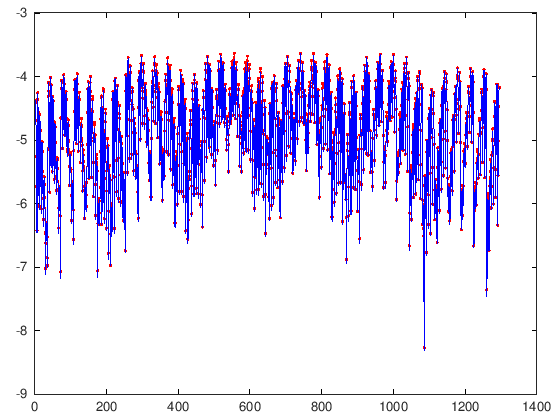

In [103]:
%%octave

close all

modelpredict=[];
srcnum=size(xi(:), 1);
for i=1:srcnum  % loop each source
   modelpredict=[modelpredict; cwfluence(sub2ind(size(cwfluence), round(reconcfg.detpos(:,1)), round(reconcfg.detpos(:,2)), round(reconcfg.detpos(:,3)), ones(srcnum,1), ones(srcnum,1), i*ones(srcnum,1)))];
end

plot(1:length(modelpredict), log10(modelpredict), 'r.-', 1:length(measurements), log10(measurements), 'b-')

Visualize the forward solutions using initial guess



srcidx = 28

zslice = 2

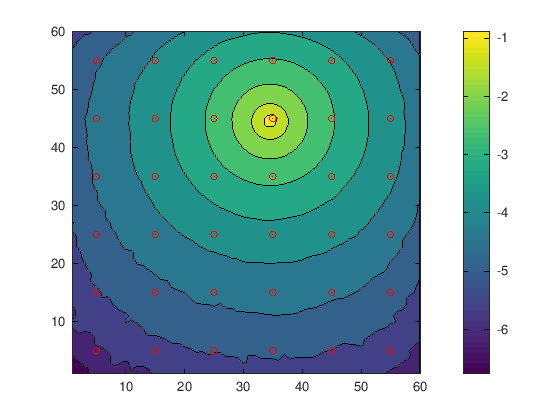

In [130]:
%%octave

srcidx = 28 # @param {type:"slider", min:0, max:72, step:1}
zslice = 2 # @param {type:"slider", min:0, max:30, step:1}

contourf(log10(abs(cwfluence(:,:,2,1,1,srcidx))))
colorbar
hold on;
plot(xi(:), yi(:), 'ro')

Building the Jacobian matrix using the adjoint method

ans =

   1296     60     60     30

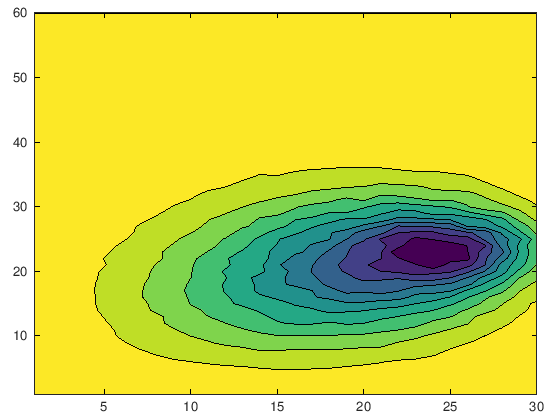

In [111]:
%%octave

jacob=zeros([length(modelpredict) size(cfg0.vol)]);
size(jacob)

detnum=size(reconcfg.detpos,1);
for i=1:srcnum
    for j=1:detnum
        jacob((i-1)*detnum + j,:,:,:)=-cwfluence(:,:,:,1,1,i).*cwfluence(:,:,:,1,1,j+srcnum);
    end
end

contourf(squeeze(jacob(15, :, 30, :)))

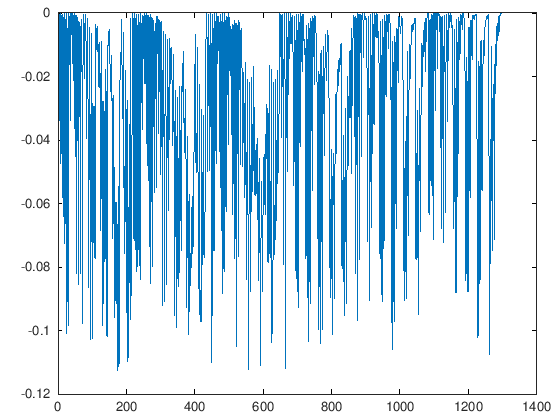

In [112]:
%%octave

plot(log10(measurements) - log10(modelpredict))

In [ ]:
%%octave

size(jacob(:,:))
size(measurements)
size(modelpredict)

dmua = rbreginv(jacob(:,:), measurements-modelpredict, 1e-8);


dims = size(reconcfg.vol)
dmua = reshape(dmua, dims(2:4));

% groupd-truth mua
mua_truth=reshape(squeeze(cfg0.prop(cfg0.vol+1,1)), dims(2:4));
size(mua_truth)
max(mua_truth(:))

zslice = 18

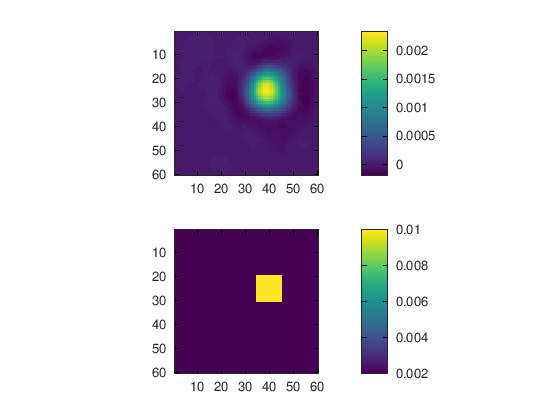

In [127]:
%%octave

zslice = 18 # @param {type:"slider", min:0, max:30, step:1}

close all
figure;
subplot(211)
imagesc(squeeze(dmua(:, :, zslice)))
axis equal
colorbar


subplot(212)
imagesc(squeeze(mua_truth(:, :, zslice)))
axis equal
colorbar